In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-poster')
from matplotlib import cm
from log_progress import log_progress
# add -a flag in cython to profile code

In [2]:
%load_ext Cython

In [87]:
%%cython --compile-args=-ffast-math --compile-args=-funroll-loops --compile-args=-ftree-loop-distribution --compile-args=-mtune=native
# distutils: language = c++

cimport cython
cimport numpy as np
import numpy as np
from libcpp.vector cimport vector
from libcpp cimport bool

from libc.math cimport exp, pi, cos, sin, sqrt, pow
from libc.stdlib cimport rand, srand
cdef extern from "limits.h":
    int RAND_MAX

cdef class XYmodel:
    """Assume that J = 1"""
    cdef public float T
    cdef public int size
    cdef np.float64_t[:, :] lattice
    
    def __init__(self, int lattice_size, float T, bool random_start):
        self.T = T
        self.size = lattice_size
        self.lattice = self.random_init(lattice_size, random_start)
        srand(1)
    
    @property
    def lattice(self):
        return np.asarray(self.lattice)
    
    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef random_init(self, int size, bool random_start):
        tmp = np.empty((size, size))
        cdef np.float64_t[:, :] array = tmp
        cdef int i, j
        for i in range(size):
            for j in range(size):
                if random_start:
                    # hot start
                    # (-pi, pi)
                    array[i][j] = pi * (2 * rand() / RAND_MAX - 1)
                else:
                    # cold start
                    array[i][j] = 0
        return array
    
    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision
    def step(self):
        cdef int x, y
        cdef np.float64_t random_spin
        cdef float delta_E, boltz
        for i in range(self.size):
            for j in range(self.size):
                # choose random spin position
                x = (rand() % self.size)
                y = (rand() % self.size)
                
                # row major not column major, add some randomness (-pi/4, pi/4)
                random_spin = self.lattice[y][x] + 0.25 * pi * (2 * rand() / RAND_MAX - 1)
                
                # make sure random_spin is in range (-pi, pi)
                if random_spin >= pi:
                    random_spin -= 2 * pi
                if random_spin < -pi:
                    random_spin += 2 * pi
                
                # calculate E_new - E
                delta_E = self._compute_E(x, y, spin=random_spin) - self._compute_E(x, y)
            
                # update spin 
                boltz = 0
                if self.T != 0:
                    boltz = exp(-delta_E / self.T)
    
                if delta_E > 0:
                    if rand() < boltz * RAND_MAX:
                        self.lattice[y][x] = random_spin
                else:
                    self.lattice[y][x] = random_spin        
    
    @cython.initializedcheck(False)
    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef _compute_E(self, int x, int y, np.float64_t spin=-9.9):
        cdef float E = 0
        right_x, left_x, up_y, down_y = self._periodic_boundary(x, y)
        # -9.9 -> just random number instead of None
        if spin != -9.9:
            # E_new
            E = -(cos(spin - self.lattice[up_y][x]) + 
                cos(spin - self.lattice[down_y][x]) + 
                cos(spin - self.lattice[y][right_x]) + 
                cos(spin - self.lattice[y][left_x]))
        else:
            # E_old
            E = -(cos(self.lattice[y][x] - self.lattice[up_y][x]) + 
                cos(self.lattice[y][x] - self.lattice[down_y][x]) + 
                cos(self.lattice[y][x] - self.lattice[y][right_x]) + 
                cos(self.lattice[y][x] - self.lattice[y][left_x]))
        return E
    
    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef _periodic_boundary(self, int x, int y):
        # periodic boundary condition
        cdef int right_x = x + 1;
        cdef int left_x = x - 1;
        cdef int up_y = y - 1
        cdef int down_y = y + 1  
        if left_x < 0:
            left_x = self.size - 1
        if right_x > self.size - 1:
            right_x = 0
        if up_y < 0:
            up_y = self.size - 1
        if down_y > self.size - 1:
            down_y = 0
        return right_x, left_x, up_y, down_y
    
    @cython.cdivision
    @cython.initializedcheck(False)
    def calculate_M(self):
        """
        Calculate magnetization per spin
        """
        cdef float M_x = 0.0, M_y = 0.0, M = 0.0
        for i in range(self.size):
            for j in range(self.size):
                M_x += cos(-1 * self.lattice[j][i])
                M_y += sin(-1 * self.lattice[j][i])
        M = sqrt(pow(M_x, 2) + pow(M_y, 2)) / pow(self.size, 2)
        return M
     
    @cython.cdivision
    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.initializedcheck(False)   
    def calculate_Part_Helicity(self):
        # https://arxiv.org/pdf/cond-mat/0304226.pdf
        # https://arxiv.org/pdf/1210.6116.pdf
        # https://arxiv.org/pdf/cond-mat/0502556.pdf
        # https://arxiv.org/pdf/1402.5017.pdf
        # https://edoc.hu-berlin.de/bitstream/handle/18452/14664/Korzec.pdf?sequence=1
        """
        Calculate helicity modulus per spin
        Y = < E (per spin) > - size^2 / T * < s^2 >
        """
        # TODO:
        cdef float s = 0.0
        for j in range(self.size):
            for i in range(self.size):
                s += (sin(self.lattice[i][j]-self.lattice[(i - 1) % self.size][j])+
                      sin(self.lattice[i][j]-self.lattice[(i + 1)% self.size][j])+
                      sin(self.lattice[i][j]-self.lattice[i][(j - 1) % self.size])+
                      sin(self.lattice[i][j]-self.lattice[i][(j + 1) % self.size]))
        s = s / (self.size ** 2)
        return s
    
    @cython.cdivision
    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.initializedcheck(False)
    def calculate_E(self):
        """
        Calculate energy per spin
        """
        cdef float E = 0.0
        for i in range(self.size):
            for j in range(self.size):
                E -= (cos(self.lattice[i][j]-self.lattice[(i - 1) % self.size][j])+
                      cos(self.lattice[i][j]-self.lattice[(i + 1) % self.size][j])+
                      cos(self.lattice[i][j]-self.lattice[i][(j - 1) % self.size])+
                      cos(self.lattice[i][j]-self.lattice[i][(j + 1) % self.size]))
        return E * 0.5 / (self.size ** 2)
    
    
# -------------------------------------
# Calculate Energy, Magnetization, Magnetic Susceptibility and Helicity Modulus
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision
def get_Energy_Mag_Sus_Hel(int L, bool random_start, float min_T=0.1, float max_T=2.5,
                       int step_T=25, int ESTEP=3000, int STEP=5000):
    """
    L - lattice size
    random_start = False => cold start
    random_start = True  => hot start
    """
    cdef vector[float] energy
    cdef vector[float] magnet
    cdef vector[float] magnet_sus
    cdef vector[float] helicity
    cdef vector[float] T_range
    cdef XYmodel xy = None
    
    energy.reserve(step_T)
    magnet.reserve(step_T)
    magnet_sus.reserve(step_T)
    helicity.reserve(step_T)
    T_range.reserve(step_T)
    
    cdef float E
    cdef float M
    cdef float M_sus
    cdef float Y
    
    cdef float by_T = (max_T - min_T) / step_T
    cdef int step
    for step in range(step_T):
        T_range.push_back(by_T + step * by_T) 
        
    cdef float T
    for T in T_range:
        xy = XYmodel(lattice_size=L, T=T, random_start=random_start)
        E, M, M_sus, Y = 0, 0, 0, 0
        # get the thermal equilibrium
        for _ in range(ESTEP):
            xy.step()
        for _ in range(STEP):
            xy.step()
            E += xy.calculate_E()
#             M += xy.calculate_M()
#             M_sus += pow(M, 2)
            Y += pow(xy.calculate_Part_Helicity(), 2)
        
        energy.push_back(E  / STEP)
        magnet.push_back(M  / STEP)
        M_sus = M_sus / STEP
        M = M / STEP
        E = E / STEP
        Y = Y / STEP
        # TODO: Something wrong!
        magnet_sus.push_back(1 / float(STEP) * (1 / xy.T) * (M_sus - pow(M, 2)))
        helicity.push_back(E - pow(xy.size, 2) / xy.T * Y)
    
    E_list = []
    M_list = []
    M_sus_list = []
    Y_list = []
    for i in range(step_T):
        E_list.append(energy[i])
        M_list.append(magnet[i])
        M_sus_list.append(magnet_sus[i])
        Y_list.append(helicity[i])
    print("Finished for L = {}".format(L))
    return E_list, M_list, M_sus_list, Y_list

In [5]:
L = 10 # lattice size
xy = XYmodel(L, T=0.9, random_start=False)
for _ in range(5000):
    xy.step()

In [6]:
xy.calculate_E()

-1.3605386352539062

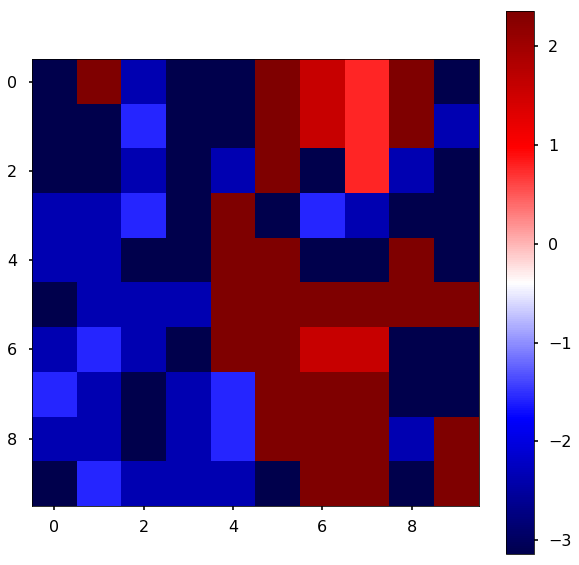

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(xy.lattice, cmap=cm.seismic)
plt.colorbar()
plt.show()

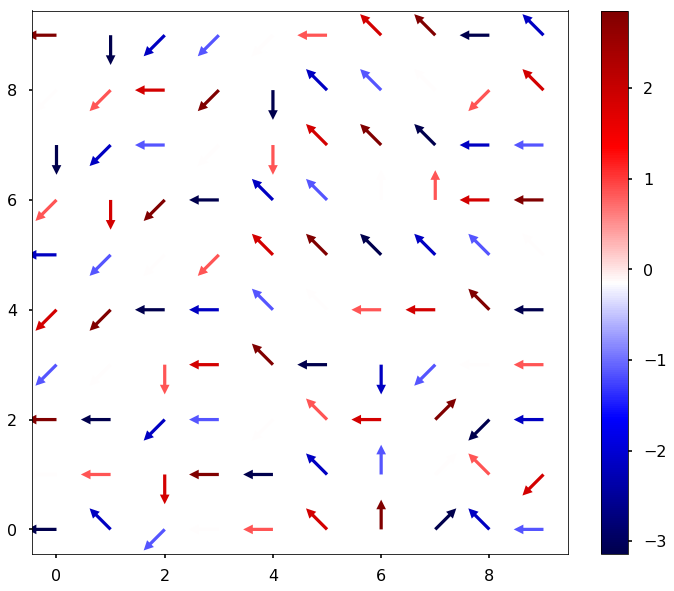

In [8]:
X, Y =  np.meshgrid(np.arange(xy.size), np.arange(xy.size))
U = np.cos(xy.lattice.flatten())
V = np.sin(xy.lattice.flatten())

C = np.arange(-np.pi, np.pi)

plt.figure(figsize=(12, 10))
plt.quiver(X, Y, U, V, C, headwidth=3, headaxislength=3, headlength=3, width=0.006, cmap=cm.seismic)
plt.colorbar()
plt.show()

# Calculate Energy and Magnetization

In [88]:
random_start = True
E_10,  M_10,  M_sus_10, Y_10  = get_Energy_Mag_Sus_Hel(L=10, random_start=random_start)
# E_30,  M_30,  M_sus_30, Y_30  = get_Energy_Mag_Sus(L=30, random_start=random_start)
# E_60,  M_60,  M_sus_60 , Y_60 = get_Energy_Mag_Sus(L=60, random_start=random_start)
# E_100, M_100, M_sus_100, Y_100 = get_Energy_Mag_Sus(L=100, random_start=random_start)

Finished for L = 10


In [89]:
Y_10

[-3.791917562484741,
 -3.7515413761138916,
 -3.6794371604919434,
 -3.6039817333221436,
 -3.503615140914917,
 -3.398819923400879,
 -3.2732253074645996,
 -3.1430344581604004,
 -2.9775216579437256,
 -2.7883505821228027,
 -2.547957420349121,
 -2.3038175106048584,
 -1.9966202974319458,
 -1.7840790748596191,
 -1.641027569770813,
 -1.5336732864379883,
 -1.4248565435409546,
 -1.3125085830688477,
 -1.2666168212890625,
 -1.1645958423614502,
 -1.0769082307815552,
 -1.0324198007583618,
 -0.9805015921592712,
 -0.9421074390411377,
 -0.8922640681266785]

In [54]:
np.savetxt("simulation_results/magnetization_L_10_ESTEP_70000_STEP_50000.txt", np.stack((T_range, M_10)).T)

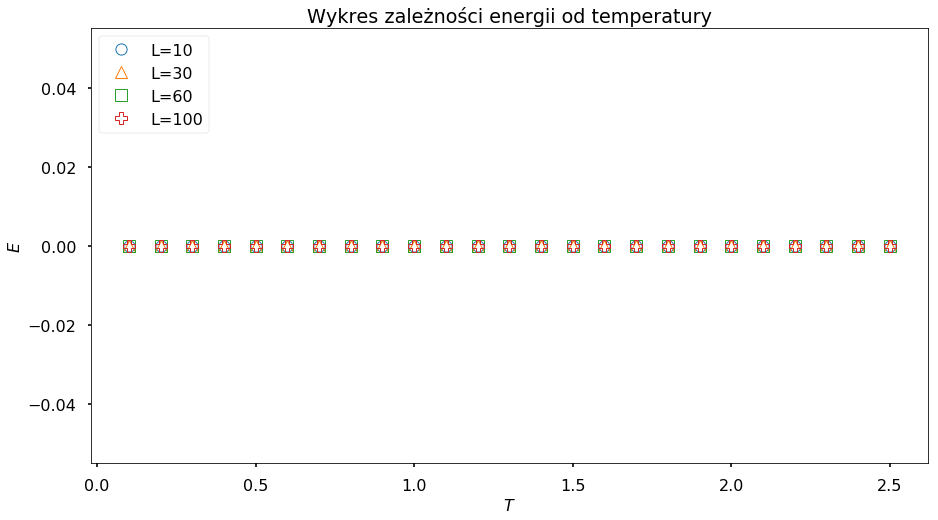

In [11]:
min_T = 0.1
max_T = 2.5
step_T = 25
T_range = np.linspace(min_T, max_T, step_T)

plt.figure(figsize=(15, 8))
plt.plot(T_range, E_10, 'o', label='L=10', markerfacecolor='none', markeredgewidth=1.0)
plt.plot(T_range, E_30, '^', label='L=30', markerfacecolor='none', markeredgewidth=1.0)
plt.plot(T_range, E_60, 's', label='L=60', markerfacecolor='none', markeredgewidth=1.0)
plt.plot(T_range, E_100, 'P', label='L=100', markerfacecolor='none', markeredgewidth=1.0)

plt.xlabel("$T$", fontsize=16)
plt.ylabel("$E$", fontsize=16)
plt.title("Wykres zależności energii od temperatury")
plt.legend(loc='upper left')
# plt.savefig("Energia.svg", dpi=800, bbox_inches='tight', format="svg")
plt.show()

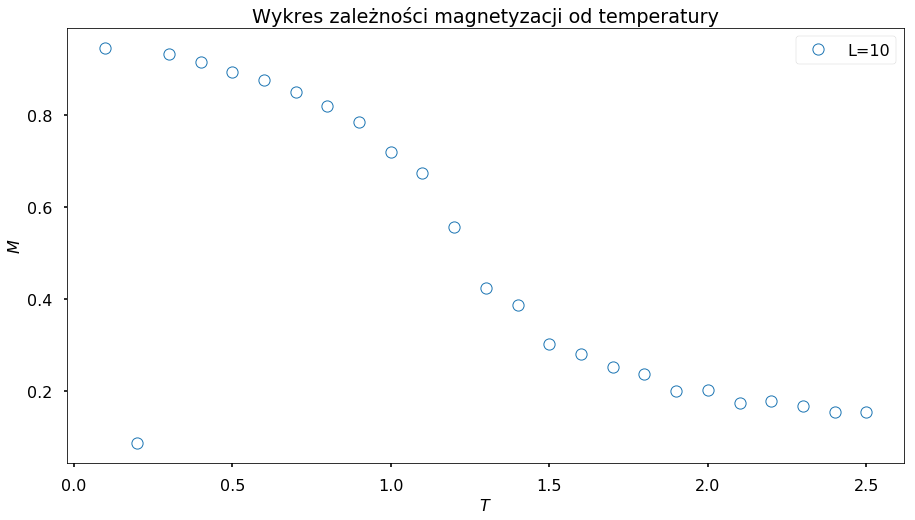

In [59]:
plt.figure(figsize=(15, 8))
plt.plot(T_range, M_10, 'o', label='L=10',  markerfacecolor='none', markeredgewidth=1.0)
plt.plot(T_range, M_30, '^', label='L=30',  markerfacecolor='none', markeredgewidth=1.0)
plt.plot(T_range, M_60, 's', label='L=60',  markerfacecolor='none', markeredgewidth=1.0)
plt.plot(T_range, M_100, 'P', label='L=100',  markerfacecolor='none', markeredgewidth=1.0)

plt.xlabel("$T$", fontsize=16)
plt.ylabel("$M$", fontsize=16)
plt.title("Wykres zależności magnetyzacji od temperatury")
plt.legend()
# plt.savefig("Magn.svg", dpi=800, bbox_inches='tight', format="svg")
plt.show()

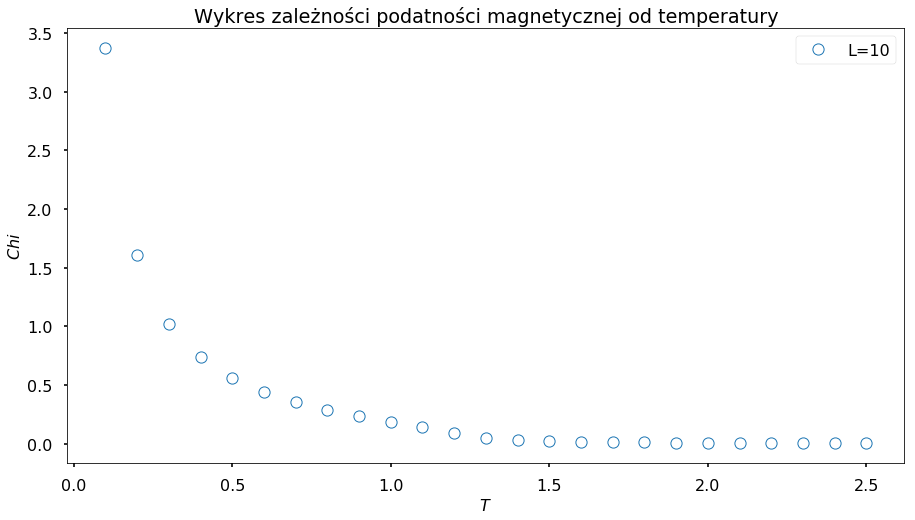

In [73]:
plt.figure(figsize=(15, 8))
plt.plot(T_range, M_sus_10, 'o', label='L=10',  markerfacecolor='none', markeredgewidth=1.0)
# plt.plot(T_range, M_sus_30, '^', label='L=30',  markerfacecolor='none', markeredgewidth=1.0)
# plt.plot(T_range, M_sus_60, 's', label='L=60',  markerfacecolor='none', markeredgewidth=1.0)
# plt.plot(T_range, M_sus_100, 'P', label='L=100',  markerfacecolor='none', markeredgewidth=1.0)

plt.xlabel("$T$", fontsize=16)
plt.ylabel("$Chi$", fontsize=16)
plt.title("Wykres zależności podatności magnetycznej od temperatury")
plt.legend()
# plt.savefig("Chi.svg", dpi=800, bbox_inches='tight', format="svg")
plt.show()

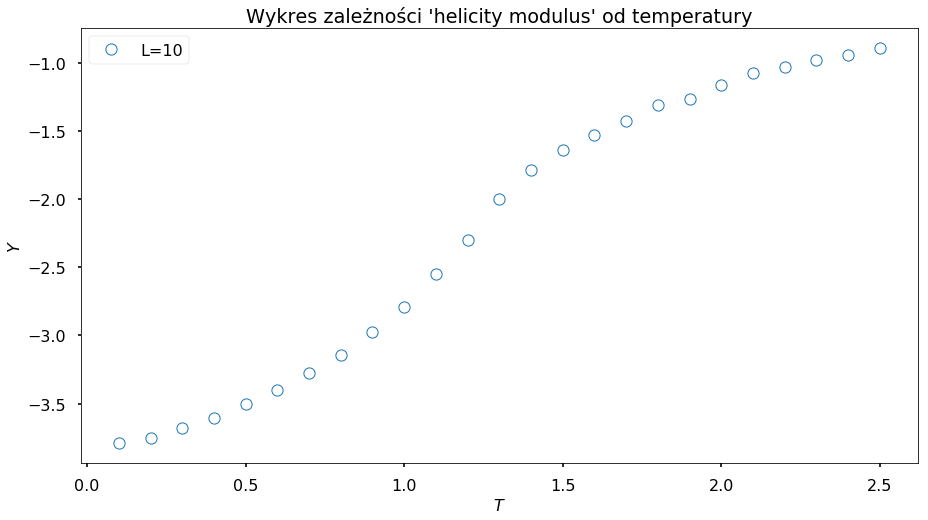

In [90]:
plt.figure(figsize=(15, 8))
plt.plot(T_range, Y_10, 'o', label='L=10',  markerfacecolor='none', markeredgewidth=1.0)
# plt.plot(T_range, Y_30, '^', label='L=30',  markerfacecolor='none', markeredgewidth=1.0)
# plt.plot(T_range, Y_60, 's', label='L=60',  markerfacecolor='none', markeredgewidth=1.0)
# plt.plot(T_range, Y_100, 'P', label='L=100',  markerfacecolor='none', markeredgewidth=1.0)

plt.xlabel("$T$", fontsize=16)
plt.ylabel("$Y$", fontsize=16)
plt.title("Wykres zależności 'helicity modulus' od temperatury")
plt.legend()
# plt.savefig("Helicity.svg", dpi=800, bbox_inches='tight', format="svg")
plt.show()